In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import expected_cumulative_transactions

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_period_transactions

from lifetimes.fitters.modified_beta_geo_fitter  import ModifiedBetaGeoFitter
from lifetimes import GammaGammaFitter

from random import sample
from random import seed


from lifetimes.generate_data import modified_beta_geometric_nbd_model


# Introduction:
In this study, we will do the **Frequency/Recency analysis** of a widgets ecommerce store using the **Modified Beta Geometric (BG) model**. Then we will estimate the **customer Lifetime Value** using **the Gamma Gamma model**. 
<br> This study is based on the papers **''The value of simple models in new product forecasting and customer-base analysis''** from **Peter S. Fader and Bruce G. S. Hardie** and **“Counting Your Customers” the Easy Way:An Alternative to the Pareto/NBD Model** from **Peter S. Fader, Bruce G. S. Hardie and Ka Lok Lee**

In [2]:
transaction_data = pd.read_csv("data-science-exercise-data.csv")  #Load the dataset 
transaction_data.head(2)

,CustomerID,Timestamp,PurchaseValue
0,5611860a94204a4078659f1667372cc4,2017-02-09T18:31:00Z,4.72
1,07b260307114f9cffc5601eb7ad4b565,2017-06-28T19:26:00Z,5.33


In [3]:
print(transaction_data.describe(), transaction_data.info())  #Retrieve the data type and statistic from our dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49945 entries, 0 to 49944
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     49945 non-null  object 
 1   Timestamp      49945 non-null  object 
 2   PurchaseValue  49945 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB
       PurchaseValue
count   49945.000000
mean      236.888196
std       245.760987
min         4.720000
25%        97.100000
50%       166.660000
75%       286.790000
max     11599.680000 None


# Definitions
- **Frequency** :  Represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases
- **Recency:**  represents the age of the customer when they made their most recent purchases
- **T:**  represents the age of the customer in whatever time units chosen. This is equal to the duration between a customer’s first purchase and the end of the period under study

In [4]:
# Group the data by customer
summary = summary_data_from_transaction_data(transaction_data, 'CustomerID', 'Timestamp', monetary_value_col='PurchaseValue')
summary.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\lifetimes\utils.py:265: UserWarning: Converting to Period representation will drop timezone information.
  pd.to_datetime(transactions[datetime_col].max(), format=datetime_format).to_period(freq).to_timestamp()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


,frequency,recency,T,monetary_value
CustomerID,,,,
0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280
00028502859fd7e111d88c20456b59d5,0.0,0.0,342.0,0.000
000306d200fd6e9b03de48d15348f5c2,0.0,0.0,33.0,0.000
0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065
000784b838b807ad589d4bc69c0c562f,0.0,0.0,210.0,0.000


# 1. Implement the modified BG model from the lifetimes package using the data we provide

In [5]:
mbgf = ModifiedBetaGeoFitter(penalizer_coef=0.0)   #Load the Modified Beta Geo Fitter
mbgf.fit(summary['frequency'], summary['recency'], summary['T'])
print(mbgf)

<lifetimes.ModifiedBetaGeoFitter: fitted with 23708 subjects, a: 0.54, alpha: 85.27, b: 1.45, r: 0.79>


In [6]:
mbgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.785759,0.046302,0.695007,0.876512
alpha,85.266166,3.666483,78.079859,92.452472
a,0.536125,0.039949,0.457825,0.614425
b,1.446923,0.202440,1.050141,1.843705


# 2. List the 100 customers predicted to make the most purchases over the next 12 months.
Let’s return to our customers and rank them from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [7]:
t = 360    #  unit of time period is in days / 12 months  = 12 * 30 = 360 days 
summary['predicted_purchases'] = mbgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases', ascending=False, inplace=True)   #Order by predicted purchases
summary.head()

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
a5fadc51b1ae844ad9a70ad3cfa46a64,95.0,371.0,371.0,433.962632,63.707709
48a503edbaded96a3be27deee11967a1,46.0,363.0,371.0,220.476739,30.552988
9f447f9415a380ac2eeee7df49c6ee7e,23.0,163.0,166.0,110.196522,25.661659
5f01420f0edda6555df5ce1cc62b986c,39.0,350.0,370.0,299.122821,24.758709
8d2ce54737dd404d20cadf1405d46dc8,33.0,360.0,362.0,123.195152,22.646241


In [8]:
#List of customers with the most purchases 
top_100_customers_most_purchases = summary.index[:100].to_list()

# 3. List the 100 customers predicted to spend the most over the next 12 months.

**The Gamma-Gamma model** 

- **Assumption:** The Gamma-Gamma submodel, assumes that **there is no relationship between ``the monetary value`` and the purchase ``frequency``**. 

We need to check whether **the Pearson correlation** between the two vectors is **close to 0** in order to use this model.

In [9]:
#We only consider customer that came back at least once (frequency >=1) to be compliant to the assumption corr(frequency, monetary_value) = 0
returning_customers = summary[summary['frequency']>0]  
returning_customers.head()

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
a5fadc51b1ae844ad9a70ad3cfa46a64,95.0,371.0,371.0,433.962632,63.707709
48a503edbaded96a3be27deee11967a1,46.0,363.0,371.0,220.476739,30.552988
9f447f9415a380ac2eeee7df49c6ee7e,23.0,163.0,166.0,110.196522,25.661659
5f01420f0edda6555df5ce1cc62b986c,39.0,350.0,370.0,299.122821,24.758709
8d2ce54737dd404d20cadf1405d46dc8,33.0,360.0,362.0,123.195152,22.646241


In [10]:
returning_customers[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.042791
frequency,0.042791,1.000000


- **Validation**: The correlation between the ``frequency`` and ``monetary value`` **0.042791**, close to 0. At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [11]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 9647 subjects, p: 4.57, q: 3.65, v: 135.88>

In [12]:
avg_profit_per_customer = ggf.conditional_expected_average_profit(summary['frequency'], summary['monetary_value']) #Predicted expected expenses per customer
returning_customers["avg_profit"] = avg_profit_per_customer
returning_customers["total_expenses"] = returning_customers.predicted_purchases * returning_customers.avg_profit
returning_customers.sort_values("total_expenses", ascending = False, inplace = True)  #Order by total expenses
returning_customers.head()

,frequency,recency,T,monetary_value,predicted_purchases,avg_profit,total_expenses
CustomerID,,,,,,,
a5fadc51b1ae844ad9a70ad3cfa46a64,95.0,371.0,371.0,433.962632,63.707709,432.751074,27569.579558
ca2202a96c2de6ca6b8a37a4a73fa730,7.0,12.0,20.0,1399.634286,15.461482,1310.471093,20261.825591
dca76db00cc59dfbcdcc97c8bbc7f9f1,19.0,339.0,364.0,966.423158,12.474960,944.737335,11785.560116
5ac5ed64cd99ed2a8403b7a927e644ef,23.0,222.0,250.0,627.439565,17.711866,617.769916,10941.858015
60c19a709e3ced2d16d7100eb1069df5,10.0,292.0,300.0,1259.266000,7.977698,1203.080039,9597.808854


In [13]:
top_100_customers_most_expenses = returning_customers.index[:100].to_list()

# 4.Analysis: Explain the model's assumptions

### **First assumption**: 
While active, **the number of transactions made by a customer follows a Poisson process with transaction rate λ**   
<p> Let's call the variable t the time between two transactions. Then t is distributed exponentially with a transation rate λ following the relation
<p>    $$f(t_j|t_{j-1},λ) = λ\exp(-λ(t_j - t_{j-1}))$$
<p> First we need to make sure that we have enough data to consider a probabilistic distribution

count    23708.000000
mean         1.025477
std          2.111326
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         95.000000
Name: frequency, dtype: float64
Number of customer with frequency of max 2: 0.8693689893706765


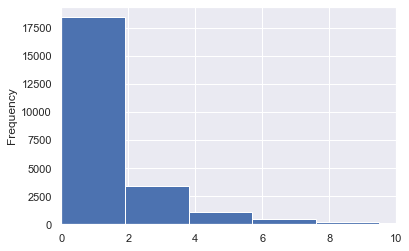

In [14]:
summary['frequency'].plot(kind='hist', bins=50)
plt.xlim(0,10)
print(summary['frequency'].describe())

n_customer_less_2_repeated = (summary['frequency'] <= 2).mean()
print(f'Number of customer with frequency of max 2: {n_customer_less_2_repeated}')


We observe that **87%** of the dataset did not purchase more than 2 items the whole year. This is predictable given the lifetime of widgets which are not perishable items and can last at least 6 months usually.High heterogeneity in ecommerce widget purchases will certainly
the precision of the models.
<p> We want to study the distribution of t for different customers. For the sake of consistency, let's consider customers that made at least 10 purchases (population >= 10). 
<p> Then, let's see if the variable t verify one property of the exponential distribution 
    $$Exp(t) = std(t) = 1/\lambda$$

In [15]:
data = transaction_data.copy()
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.sort_values('Timestamp', inplace=True)

In [16]:
def exp_and_var(x):  #This function compute for each customer the mean inter_purchase time and its standard deviation 
    x = x['Timestamp'].diff().apply(lambda x: x.total_seconds())[1:] / (60*60*24)
    return pd.Series([x.mean(), x.std(), len(x)], index=['mean', 'std', 'number of purchases'])

In [17]:
diff_time = data.groupby('CustomerID').apply(exp_and_var)   # 5 min to run 
diff_time.dropna(inplace=True)
diff_time.head()

,mean,std,number of purchases
CustomerID,,,
0003f3458a6e7b495a975c2d9ddda559,142.462500,198.834498,2.0
000ad0f90e9fcb6ff5a0bc480cccbdb3,13.528889,17.817250,5.0
000c6eab0c01eddd654c20fab4182dae,41.261111,39.335474,4.0
000e87f1b3e38300a489eb3a6eef2dab,147.072917,112.713803,2.0
0017a05a282eabcfa07b36fa12f03440,60.780694,50.195049,5.0


In [18]:
diff_time["mean"].mean()

56.77715364476355

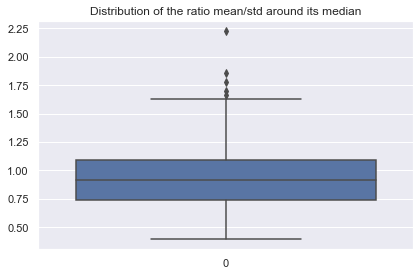

In [19]:
#We consider as 10 the population size that starts to represent the distribution of the variable 
a = diff_time.loc[diff_time['number of purchases']>=10]  
sns.boxplot(data = a['mean']/a['std'])
plt.title("Distribution of the ratio mean/std around its median")
plt.tight_layout()

Considering only the data that allows us to evaluate a distribution of the time between two transactions (number of transactions >= 10), We observe that the distribution of the ratio between the mean and the std has a **median close to 1** and the **inter quartile range is centered around 1**. We then almost have $Exp(t) = std(t) = 1/\lambda$. 
- **Thus, the assumption that t is distributed exponentially with a transation rate λ following the relation is reasonable**.

### **Second assumption**: 
Heterogeneity in transaction rates $\lambda$ across customers follows a **gamma distribution** with shape parameter r and scale parameter α and
     $$\lambda = \dfrac{1}{\mathbb{E}(t)}$$
To verify this assumption, we conduct **chi squared and Kolmogorov Smirnov tests** and plot the **qqplot** of the gamma distribution and our $\lambda$ to visually assess the goodness of fit of both distributions.

In [20]:
lbd = 1/a["mean"]  #Lambda

(0, 0.5)

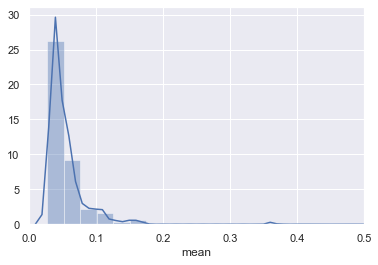

In [21]:
sns.distplot(lbd)  
plt.xlim(0,0.5)

In [22]:
import scipy
from sklearn.preprocessing import StandardScaler
import scipy.stats

In [23]:
y = lbd.to_numpy()
x = np.arange(len(y))
size = len(y)  

In [24]:
sc=StandardScaler() 
yy = y.reshape (-1,1)
sc.fit(yy)
y_std =sc.transform(yy)
y_std = y_std.flatten()
y_std
del yy

In [25]:
import warnings
warnings.filterwarnings("ignore")  # Turn off code warnings

#Borrowed from https://pythonhealthcare.org/2018/05/03/81-distribution-fitting-to-data/

dist_names = ['gamma','beta','norm']


chi_square = []
p_values = []

# Set up 50 bins for chi-square test
# Observed data will be approximately evenly distrubuted aross all bins
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(y_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

# Loop through candidate distributions

for distribution in dist_names:
    
    dist = getattr(scipy.stats, distribution)  # Set up distribution and get fitted distribution parameters
    param = dist.fit(y_std)
    
    
    p = scipy.stats.kstest(y_std, distribution, args=param)[1]  # Obtain the KS test P statistic, round it to 5 decimal places
    p = np.around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distrubution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
1         beta    202.345765  0.00537
2         norm   3823.677262  0.00000
0        gamma  20119.565590  0.00000


For our limited data, compared to other distributions, regarding the chi_square and p_value of both tests, the gamma distribution is not the best fit 

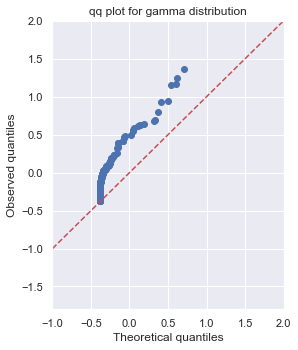

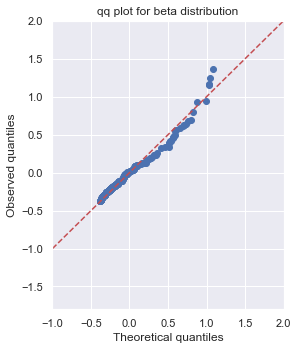

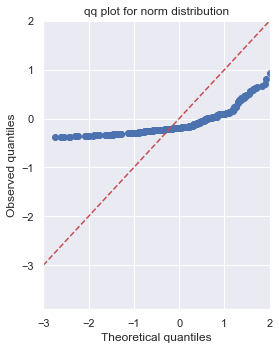

In [26]:
## qq plot
    
data = y_std.copy()
data.sort()

# Loop through selected distributions (as previously selected)

for distribution in dist_names:
    # Set up distribution
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Get random numbers from distribution
    norm = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = size)
    norm.sort()
    
    # Create figure
    fig = plt.figure(figsize=(9,6)) 
    
    # qq plot
    ax1 = fig.add_subplot(121) # Grid of 2x2, this is suplot 1
    ax1.plot(norm,data,"o")
    min_value = np.floor(min(min(norm),min(data)))
    max_value = np.ceil(max(max(norm),max(data)))
    ax1.plot([min_value,max_value],[min_value,max_value],'r--')
    ax1.set_xlim(min_value,max_value)
    ax1.set_xlabel('Theoretical quantiles')
    ax1.set_ylabel('Observed quantiles')
    title = 'qq plot for ' + distribution +' distribution'
    ax1.set_title(title)
    
    # Display plot    
    plt.tight_layout(pad=4)
    plt.xlim(right=2)
    plt.ylim(top=2)
    plt.show()

- **For this data, both Chi_squared and Kolmogorov Smirnov tests and QQ plot support that the gamma distribution is not a good fit for the distribution of the transaction rate amongst customers. Instead, the Beta distribution seems like a better fit**.

### **Third assumption**: 
<p> The point at which the customer “drops out” is distributed across transactions according to a (shifted) geometric distribution.
<p> In this framework, the author consider that a dropout can occur immediately after a transaction.This assumption is relevant since after any transaction, a customer can "dead". If we assign a probability p to this event, the maximum likelihood estimation can be an effective way to evaluate that probability. 
    $$Prob= p(1 − p)^{j−1}$$ 
    
<p> We thus can assume a geometric distribution under this premise 

### **Fourth assumption**: 
The purchase rate λ and the dropout rate μ vary independently across customers.
<p> It is asafe to assume that each customer, given his financial situation has his own personal buying habits even though we can note a small dependance in consumption based on products' reviews and marketing campaigns.

### **Conclusion:**
The widgets ecommerce store is a **continuous noncontractual** settings' problem. On overall its assumptions fairly fits the problem setting.
**It it is not unreasonable to use the Modified Beta Gamma model as in the studies of Fader and Hardie for this problem.**

# 5. Write a simulation

Simulate how many customers are alive after 10 days, 1 year, 10 years and 100 years
and how many purchases they have made in that time using the modified BG model.
Use a random sample of 100 customers and show the results for 1 run of your
simulation. We’ve outlined a possible approach below:
- Generate a random sample of 100 customers.
- Simulate how each customer makes purchases over time.
- Count how many purchases the customers have made in 10 days.
- Count how many customers are alive after 10 days.
- Repeat b-d for 1 year, 10 years, 100 years.
- Tip: Your simulation should show a different number of customers alive each time the code is evaluated. (Often it is interesting to look at this range of values, but for this exercise, we are only looking for you to show us the result of one run.)

In [27]:
def simulation(t): # t the length of time observing new customers.
    sample = modified_beta_geometric_nbd_model(T=t, r=0.79, alpha=85.27, a=0.54, b=1.45, size=100)
    count_purchases = sample.frequency.sum()
    nb_alive = sample.alive.sum()
    return count_purchases, nb_alive

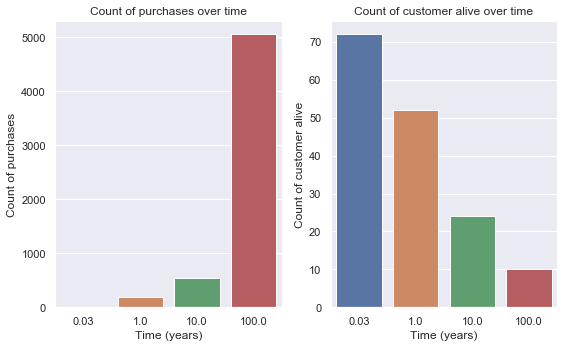

In [28]:
sim_days = [10, 365, 3650, 36500]  #10 days, 1 year = 365 days, 10 years = 3650 days, 100 years = 36500 days
x = [0.03, 1, 10, 100]
purchases = []
nb_alive = []
for days in sim_days:
    a, b = simulation(days)
    purchases.append(a)
    nb_alive.append(b)

fig, ax =plt.subplots(1,2, figsize=(8,5))
sns.barplot(x, y=purchases, ax=ax[0])
sns.barplot(x, y=nb_alive, ax=ax[1])
ax[0].set_title('Count of purchases over time') 
ax[0].set_ylabel('Count of purchases') 
ax[0].set_xlabel('Time (years)') 
ax[1].set_title('Count of customer alive over time') 
ax[1].set_ylabel('Count of customer alive') 
ax[1].set_xlabel('Time (years)') 
plt.tight_layout()

# 6.Analysis of the results

## What the model does well

**Assessing model fit**
<p> Assuming the forementionned hypotheses we can assess the goodness of fit of the model to convince ourselves its relevance on this data. We can compare our data versus artificial data simulated with our fitted model’s parameters.

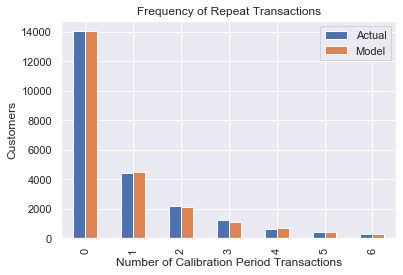

In [29]:
plot_period_transactions(mbgf)

In this graph, we **compare the expected number of people to make [0-6] repeated transactions to the actual frequency distribution**. We can see that **our actual data and our simulated data line up well.** 
<p> Now let us assess how well the models track the actual number of repeat transactions over time. we consider the cumulative number of repeat transactions.

In [30]:
transaction = transaction_data.copy()
transaction['date'] = pd.to_datetime(transaction_data.Timestamp)
#transaction

In [31]:
data_cumul = expected_cumulative_transactions(mbgf, transaction,  customer_id_col= 'CustomerID', datetime_col = 'date', t=365 )
r2 = r2_score(data_cumul.actual, data_cumul.predicted)
sns.lineplot(data = data_cumul, x=data_cumul.index, y="actual", label="actual" )
sns.lineplot(data = data_cumul, x=data_cumul.index, y="predicted", label="predicted")
plt.xlabel("days")

NameError: name 'r2_score' is not defined

The model demonstrates superb tracking capabilities. It closely matches the cumulated actual probabilities over time. Futhermore, we need to evaluate how the model performs on unseen data.

### Limits to its applications

Now we will train our model from November 2016 until October 2017 then evaluate its performance on the last two months November and December 2017.


In [32]:
print("start date=",pd.to_datetime(transaction_data.Timestamp).min(), " end date=",pd.to_datetime(transaction_data.Timestamp).max())

start date= 2016-11-30 04:47:00+00:00  end date= 2017-12-06 17:53:00+00:00


In [33]:
#We holdout the last 2 months of historical data
summary_cal_holdout = calibration_and_holdout_data(transaction, customer_id_col= 'CustomerID',
                                                   datetime_col = 'date', calibration_period_end = "2017-10-06 00:00:00+00:00")

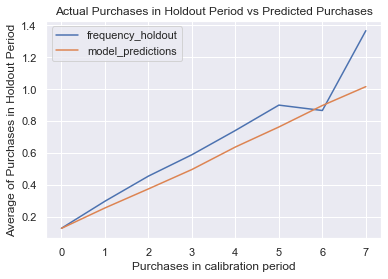

In [34]:
mbgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(mbgf, summary_cal_holdout, n=8)

- The holdout data is the period of November and December. At the Christmas season we have a surge in purchases not followed by the model. **The model is less efficient during the christmas season, and eventually on the extent of seasonal purchase behavior.**

- With the simulation of number of purchases and the number of customers alive over time, we observe that **the count of customers alive become pretty unlikely when it comes to 10-100 years**. The current customers will certainly be "dead" before that time especically since the prediction is only based on their historical habits and we don't consider their age. We consider that consumption changes with age.  

# 7. Ideas to address the deficiencies of the model

- First, for long term prediction it is difficult to predict a customer purchasing behavior especially in the scale of years. Generally speaking, to adapt to the variation of customers' habit, **the model should be applied separately to customer cohorts defined by the time (e.g., quarter) of acquisition, acquisition channel as stated in the work of Blattberg et al. 2001**. Then we will have to be confident about the comparabilty of the different cohorts to extrapolate one's parameters to the other.

- Second, we should **include in the BG/NBD some external features such as demographics or measures of marketing activity to which a cohort is exposed**.

# 8.Explain 

Suppose the intended use of the modified BG model is binning customers into one of the
following categories: highly likely to purchase in the next year, somewhat likely to
purchase in the next year, unlikely to purchase in the next year, highly unlikely to
purchase in the next year. Suppose you want to compare this model with a model your
colleague is proposing. How would you evaluate the two models? Do not implement, but
do show a mockup of the results of your evaluation.

In [35]:
from IPython.display import Image

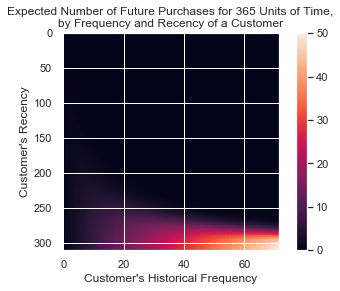

In [36]:
plot_frequency_recency_matrix(mbgf, T=365)

In [37]:
#Please do not run the following cell to save the image

Here is a matrix of the probability of being still being alive at the end of our historical data depending on the customer recency and frequency. Based on this matrix we can partition our data in four portions using different thresholds.
- **Type 1:** Highly likely to purchase in the next year, they purchased recently and have been frequent, they are almost surely alive
- **Type 2:** Somewhat likely to purchase in the next year, They are recent but have been less frequent than Type 1
- **Type 3:** Unlikely to purchase in the next year, they haven't purchased recently and where not frequent
- **Type 4:** Highly unlikely to purchase in the next year
<p>
    
![frequency matrix](question_8.JPG)

This can be considered as a **4 labels classification problem**. We can use **accuracy** as evaluation metrics. To compare this model with another, we can use the **confusion matrix** of the problem. We train our algorithm on a training set, then compare the performances on the test set using the confusion matrix. The best model will be the one with the highest accuracy (**depending on management's decisions we can also use the precision, recall for evaluation**).
<P> On our test set we choose to partition our dataset according to our above matrix following the rules: 
- Type 1 predicted purchases in [30,50]: Customers who have purchased a lot and purchased recently will likely be the best customers in the future
- Type 2 predicted purchases in [2,30]: As recent as Type 1 but less frequent will probably buy less than Type 1 in the future
- Type 3 predicted purchases in [0,1]: Customers who have made a few purchases could be "dead" or light buyers
- Type 4 predicted purchases in [0]: Customers who have purchased a lot, but not recently, have probably dropped out.
    
